In [2]:
import pandas as pd
import numpy as np

import folium
import io

import requests
import seaborn as sns

import scipy
import scipy.stats as sp
import scipy.optimize as op
import statsmodels.api as sm

from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy import stats
#from pandas.stats.api import ols
from datetime import date, timedelta
import datetime
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib
import matplotlib as mpl
import matplotlib.cm as cm
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
rcParams['pdf.fonttype'] = 42
inline_rc = dict(plt.rcParams)

#from matplotlib.pyplot import cm 
import platform
import sys
import glob
import time
import folium

import pyproj
from pyproj import CRS
from pyproj import Transformer


import geopandas
import contextily as ctx
from shapely.geometry import Point

import windrose
from windrose import WindroseAxes

from contextlib import closing
import csv

import pyproj
from pyproj import Proj


import os

import wellapplication as wa

from numba import njit

In [ ]:
def calc_pV(self, Ea, Ts):
    return (Ea * 1000.0) / (self.Rv * Ts)

def calc_Es(self, T: float) -> float:
    """
    Saturation Vapor Pressure Equation
    :param T: Water temperature in Kelvin
    :return: Saturation Vapor Pressure (Pa)
    """
    g0 = -2836.5744
    g1 = -6028.076559
    g2 = 19.54263612
    g3 = -0.02737830188
    g4 = 0.000016261698
    g5 = 0.00000000070229056
    g6 = -0.00000000000018680009
    g7 = 2.7150305

    return np.exp(
        g0 * T ** (-2) + g1 * T ** (-1) + g2 + g3 * T + g4 * T ** 2 + g5 * T ** 3 + g6 * T ** 4 + g7 * np.log(T))

#@numba.njit#(forceobj=True)
def calc_Tsa(self, Ts, P, pV, Rv=461.51):
    """
    Calculate the average sonic temperature
    :param Ts:
    :param P:
    :param pV:
    :param Rv:
    :return:
    """
    E = pV * self.Rv * Ts
    return -0.01645278052 * (
                -500 * P - 189 * E + np.sqrt(250000 * P ** 2 + 128220 * E * P + 35721 * E ** 2)) / pV / Rv

def calc_Q(self, P, E):
    return (0.622 * E) / (P - 0.378 * E)

def calc_E(self, pV, T):
    return pV * self.Rv * T

def calc_L(self, Ust, Tsa, Uz_Ta):
    #removed negative sign
    return -1*(Ust ** 3) * Tsa / (9.8 * 0.4 * Uz_Ta)



In [ ]:
'Ea': ['Actual Vapor Pressure', 'kPa'],
'LnKH': ['Natural Log of Krypton Hygrometer Output', 'mV'],
'Pr': ['Air Pressure', 'Pa'],
'Ta': ['Air Temperature', 'K'],
'Ts': ['Sonic Temperature', 'K'],
'Ux': ['X Component of Wind Speed', 'm/s'],
'Uy': ['Y Component of Wind Speed', 'm/s'],
'Uz': ['Z Component of Wind Speed', 'm/s'],
'E': ['Vapor Pressure', 'kPa'],
'Q': ['Specific Humidity', 'unitless'],
'pV': ['Water Vapor Density', 'kg/m^3'],
'Sd': ['Entropy of Dry Air', 'J/K'],
'Tsa': ['Absolute Air Temperature Derived from Sonic Temperature', 'K'],

1. rename and identify columns in raw file; Ideally, you should have Air Temperature, Air Pressure, Relative humidity, and Actual Vapor Pressure
2. If Actual Vapor Pressure is not available in the raw file, estimate it using one of the vapor pressure estimation methods.
3. Convert Temperatures from C to K.
4. Despike the raw fields and fill small gaps.
5. Fill large gaps with proxy values?
6. Fix shadow effects from the CSAT
7. Calculate secondary variables, namely Water Vapor Density, Air Temperature from Sonic, Vapor Pressure, Specific Humidity, and Entropy of Dry Air
8. If the setup has a KH20, then Calculate the Correct XKw Value for KH20
9. Calculate Basic Non-Lagged Covariances 
10. Calculate maximum covariance and shift datasets accordingly
11. Perform Traditional Coordinate Rotation
12. Find the Mean Squared Error of Velocity Components and Humidity
13. Determine Saturation Vapor Pressure of the Air Using Highly Accurate Wexler's Equations Modified by Hardy
14. Calculate the Latent Heat of Vaporization
15. Determine Vertical Wind and Water Vapor Density Covariance
16. Calculate the Correct Average Values of Some Key Parameters
17. Calculate Variance of Air Temperature From Variance of Sonic Temperature
18. Determine Saturation Vapor Pressure of the Air Using Highly Accurate Wexler's Equations Modified by Hardy
19. Calculate the Average and Standard Deviations of the Rotated Velocity Components
20. Frequency Response Corrections (Massman, 2000 & 2001)
21. Calculate ζ and Correct Values of Uᕽ and Uz_Ta
22. Recalculate L With New Uᕽ and Uz_Ta, and Calculate High Frequency Corrections
23. Correct the Covariance Values
24. KH20 Oxygen Correction
25. Calculate New H and LE Values
26. Webb, Pearman and Leuning Correction
27. Finish Output


In [ ]:
def calc_Td(E):
    """
    Dew point equation
    :param E: Water vapour pressure at saturation
    :return:
    """
    c0 = 207.98233
    c1 = -20.156028
    c2 = 0.46778925
    c3 = -0.0000092288067
    
    d0 = 1
    d1 = -0.13319669
    d2 = 0.0056577518
    d3 = -0.000075172865
    lne = np.log(E)
    return (c0 + c1 * lne + c2 * lne ** 2 + c3 * lne ** 3) / (d0 + d1 * lne + d2 * lne ** 2 + d3 * lne ** 3)

def calc_Es(self, T: float) -> float:
    """
    Saturation Vapor Pressure Equation
    :param T: Water temperature in Kelvin
    :return: Saturation Vapor Pressure (Pa)
    """
    g0 = -2836.5744
    g1 = -6028.076559
    g2 = 19.54263612
    g3 = -0.02737830188
    g4 = 0.000016261698
    g5 = 0.00000000070229056
    g6 = -0.00000000000018680009
    g7 = 2.7150305

    return np.exp(
        g0 * T ** (-2) + g1 * T ** (-1) + g2 + g3 * T + g4 * T ** 2 + g5 * T ** 3 + g6 * T ** 4 + g7 * np.log(T))

In [ ]:
def sat_vapor_press(Tavg, eavg, Pavg):
    """Determine Saturation Vapor Pressure of the Air; Uses Highly Accurate Wexler's Equations Modified by Hardy

    :param Tavg: Temperature (K)
    :param eavg: Actual Vapor Pressure (kPa)
    :param Pavg: Pressure (kPa
    :return:
    """


    es = calc_Es(Tavg)
    Td = calc_Td(eavg)
    D = es - eavg

    Tq1 = Ta - 1.0
    
    es = calc_Es(Tq1)

    qs1 = (0.622 * es) / (Pavg - 0.378 * es)
    Tq2 = Ta + 1.0

    es = calc_Es(Tq2)

    qs2 = (0.622 * es) / (Pavg - 0.378 * es)
    s = (qs2 - qs1) / 2.0
    return es, s

In [ ]:
        df = self.renamedf(df)

        if 'Ea' in df.columns:
            pass
        else:
            df['Ea'] = self.tetens(df['Ta'].to_numpy())

        if 'LnKH' in df.columns:
            pass
        else:
            df['LnKH'] = np.log(df['volt_KH20'].to_numpy())

        for col in self.despikefields:
            if col in df.columns:
                df[col] = self.despike(df[col].to_numpy(), nstd=4.5)

        df.loc[:, 'Ts'] = self.convert_CtoK(df['Ts'].to_numpy())
        df.loc[:, 'Ta'] = self.convert_CtoK(df['Ta'].to_numpy())

        df['Ux'], df['Uy'], df['Uz'] = self.fix_csat(df['Ux'].to_numpy(),
                                                   df['Uy'].to_numpy(),
                                                   df['Uz'].to_numpy())

        # Calculate Sums and Means of Parameter Arrays
        df = self.calculated_parameters(df)

        # Calculate the Correct XKw Value for KH20
        XKw = self.XKwC1 + 2 * self.XKwC2 * (df['pV'].mean() * 1000.)
        self.Kw = XKw / self.XKH20



        # Calculate Covariances (Maximum Furthest From Zero With Sign in Lag Period)
        CovTs_Ts = df[['Ts', 'Ts']].cov().iloc[0,0] # location index needed because of same fields
        CovUx_Uy = df[['Ux', 'Uy']].cov().loc['Ux', 'Uy']  # CalcCovariance(IWP.Ux, IWP.Uy)
        CovUx_Uz = df[['Ux', 'Uz']].cov().loc['Ux', 'Uz']  # CalcCovariance(IWP.Ux, IWP.Uz)
        CovUy_Uz = df[['Uy', 'Uz']].cov().loc['Uy', 'Uz']  # CalcCovariance(IWP.Uy, IWP.Uz)

        CovTs_Q = self.calc_max_covariance(df, 'Ts', 'Q', self.lag)[0]
        CovUx_LnKH = self.calc_max_covariance(df, 'Ux', 'LnKH', self.lag)[0]
        CovUx_Q = self.calc_max_covariance(df, 'Ux', 'Q', self.lag)[0]
        CovUx_Sd = self.calc_max_covariance(df, 'Ux', 'Sd', self.lag)[0]
        CovUx_Ts = self.calc_max_covariance(df, 'Ux', 'Ts', self.lag)[0]
        CovUy_LnKH = self.calc_max_covariance(df, 'Uy', 'LnKH', self.lag)[0]
        CovUy_Q = self.calc_max_covariance(df, 'Uy', 'Q', self.lag)[0]
        CovUy_Sd = self.calc_max_covariance(df, 'Uy', 'Sd', self.lag)[0]
        CovUy_Ts = self.calc_max_covariance(df, 'Uy', 'Ts', self.lag)[0]
        CovUz_LnKH = self.calc_max_covariance(df, 'Uz', 'LnKH', self.lag)[0]
        CovUz_Q = self.calc_max_covariance(df, 'Uz', 'Q', self.lag)[0]
        CovUz_Sd = self.calc_max_covariance(df, 'Uz', 'Sd', self.lag)[0]
        CovUz_Ts = self.calc_max_covariance(df, 'Uz', 'Ts', self.lag)[0]

        # Traditional Coordinate Rotation
        cosν, sinν, sinTheta, cosTheta, Uxy, Uxyz = self.coord_rotation(df)

        # Find the Mean Squared Error of Velocity Components and Humidity
        UxMSE = self.calc_MSE(df['Ux'])
        UyMSE = self.calc_MSE(df['Uy'])
        UzMSE = self.calc_MSE(df['Uz'])
        QMSE = self.calc_MSE(df['Q'])

        # Correct Covariances for Coordinate Rotation
        Uz_Ts = CovUz_Ts * cosTheta - CovUx_Ts * sinTheta * cosν - CovUy_Ts * sinTheta * sinν
        if np.abs(Uz_Ts) >= np.abs(CovUz_Ts):
            CovUz_Ts = Uz_Ts

        Uz_LnKH = CovUz_LnKH * cosTheta - CovUx_LnKH * sinTheta * cosν - CovUy_LnKH * sinν * sinTheta
        if np.abs(Uz_LnKH) >= np.abs(CovUz_LnKH):
            CovUz_LnKH = Uz_LnKH
        CovUx_Q = CovUx_Q * cosTheta * cosν + CovUy_Q * cosTheta * sinν + CovUz_Q * sinTheta
        CovUy_Q = CovUy_Q * cosν - CovUx_Q * sinν
        CovUz_Q = CovUz_Q * cosTheta - CovUx_Q * sinTheta * cosν - CovUy_Q * sinν * sinTheta
        CovUx_Uz = CovUx_Uz * cosν * (cosTheta**2 - sinTheta**2) - 2 * CovUx_Uy * sinTheta * cosTheta * sinν * cosν + CovUy_Uz * sinν * (cosTheta**2 - sinTheta**2) - UxMSE * sinTheta * cosTheta * cosν**2 - UyMSE * sinTheta * cosTheta * sinν**2 + UzMSE * sinTheta * cosTheta
        CovUy_Uz = CovUy_Uz * cosTheta * cosν - CovUx_Uz * cosTheta * sinν - CovUx_Uy * sinTheta * (cosν**2 - sinν**2) + UxMSE * sinTheta * sinν * cosν - UyMSE * sinTheta * sinν * cosν
        CovUz_Sd = CovUz_Sd * cosTheta - CovUx_Sd * sinTheta * cosν - CovUy_Sd * sinν * sinTheta
        Uxy_Uz = np.sqrt(CovUx_Uz**2 + CovUy_Uz**2)
        Ustr = np.sqrt(Uxy_Uz)

        # Find Average Air Temperature From Average Sonic Temperature
        Tsa = self.calc_Tsa(df['Ts'].mean(), df['Pr'].mean(), df['pV'].mean())

        # Calculate the Latent Heat of Vaporization
        lamb = (2500800 - 2366.8 * (self.convert_KtoC(Tsa)))

        # Determine Vertical Wind and Water Vapor Density Covariance
        Uz_pV = (CovUz_LnKH / XKw) / 1000

        # Calculate the Correct Average Values of Some Key Parameters
        Cp = self.Cpd * (1 + 0.84 * df['Q'].mean())
        pD = (df['Pr'].mean() - df['E'].mean()) / (self.Rd * Tsa)
        p = pD + df['pV'].mean()

        # Calculate Variance of Air Temperature From Variance of Sonic Temperature
        StDevTa = np.sqrt(CovTs_Ts - 1.02 * df['Ts'].mean() * CovTs_Q - 0.2601 * QMSE * df['Ts'].mean()**2)
        Uz_Ta = CovUz_Ts - 0.07 * lamb * Uz_pV / (p * Cp)

        # Determine Saturation Vapor Pressure of the Air Using Highly Accurate Wexler's Equations Modified by Hardy
        Td = self.calc_Td(df['E'].mean())
        D = self.calc_Es(Tsa) - df['E'].mean()
        S = (self.calc_Q(df['Pr'].mean(), self.calc_Es(Tsa + 1)) - self.calc_Q(df['Pr'].mean(), self.calc_Es(Tsa - 1))) / 2

        # Determine Wind Direction
        WindDirection = np.arctan(df['Uy'].mean() / df['Ux'].mean()) * 180 / np.pi
        if df['Ux'].mean() < 0:
            WindDirection += 180 * np.sign(df['Uy'].mean())

        direction = self.directionKH20_U - WindDirection

        if direction < 0:
            direction += 360

        # Calculate the Lateral Separation Distance Projected Into the Mean Wind Direction
        pathlen = self.PathKH20_U * np.abs(np.sin((np.pi / 180) * direction))

        # Calculate the Average and Standard Deviations of the Rotated Velocity Components
        StDevUz = df['Uz'].std()
        UMean = df['Ux'].mean() * cosTheta * cosν + df['Uy'].mean() * cosTheta * sinν + df['Uz'].mean() * sinTheta

        # Frequency Response Corrections (Massman, 2000 & 2001)
        tauB = (3600) / 2.8
        tauEKH20 = np.sqrt((0.01 / (4 * UMean)) **2 + (pathlen / (1.1 * UMean))**2)
        tauETs = np.sqrt((0.1 / (8.4 * UMean))**2)
        tauEMomentum = np.sqrt((0.1 / (5.7 * UMean))**2 + (0.1 / (2.8 * UMean))**2)

        # Calculate ζ and Correct Values of Uᕽ and Uz_Ta
        L = self.calc_L(Ustr, Tsa, Uz_Ta)
        alpha, X = self.calc_AlphX(L)
        fX = X * UMean / self.UHeight
        B = 2 * np.pi * fX * tauB
        momentum = 2 * np.pi * fX * tauEMomentum
        _Ts = 2 * np.pi * fX * tauETs
        _KH20 = 2 * np.pi * fX * tauEKH20
        Ts = self.correct_spectral(B, alpha, _Ts)
        Uxy_Uz /= self.correct_spectral(B, alpha, momentum)
        Ustr = np.sqrt(Uxy_Uz)

        # Recalculate L With New Uᕽ and Uz_Ta, and Calculate High Frequency Corrections
        L = self.calc_L(Ustr, Tsa, Uz_Ta / Ts)
        alpha, X = self.calc_AlphX(L)
        Ts = self.correct_spectral(B, alpha, _Ts)
        KH20 = self.correct_spectral(B, alpha, _KH20)

        # Correct the Covariance Values
        Uz_Ta /= Ts
        Uz_pV /= KH20
        Uxy_Uz /= self.correct_spectral(B, alpha, momentum)
        Ustr = np.sqrt(Uxy_Uz)
        CovUz_Sd /= KH20
        exchange = ((p * Cp) / (S + Cp / lamb)) * CovUz_Sd

        # KH20 Oxygen Correction
        Uz_pV += self.correct_KH20(Uz_Ta, df['Pr'].mean(), Tsa)

        # Calculate New H and LE Values
        H = p * Cp * Uz_Ta
        lambdaE = lamb * Uz_pV

        #'Webb, Pearman and Leuning Correction
        lambdaE = lamb * p * Cp * Tsa * (1.0 + (1.0 / 0.622) * (df['pV'].mean() / pD)) * (Uz_pV + (df['pV'].mean() / Tsa) * Uz_Ta) / (p * Cp * Tsa + lamb * (1.0 + (1 / 0.622) * (df['pV'].mean() / pD)) * df['pV'].mean() * 0.07)

        #'Finish Output
        Tsa = self.convert_KtoC(Tsa)
        Td = self.convert_KtoC(Td)
        zeta = self.UHeight / L
        ET = lambdaE * self.get_Watts_to_H2O_conversion_factor(Tsa, (df.last_valid_index() - df.first_valid_index())/ pd.to_timedelta(1, unit='D'))
        #'Out.Parameters = CWP
        self.columns = ['Ta','Td','D', 'Ustr', 'zeta', 'H', 'StDevUz', 'StDevTa',  'direction', 'exchange', 'lambdaE', 'ET', 'Uxy']
        self.out = [Tsa, Td, D, Ustr, zeta, H, StDevUz, StDevTa,  direction, exchange,  lambdaE, ET, Uxy]
        return pd.Series(data=self.out,index=self.columns)

In [111]:
def calc_max_covariance(df: pd.DataFrame, colx: str, coly: str, lags: int = 10) -> [float, int]:
    """
    Find maximum covariance between two variables
    :param df: Pandas DataFrame containing the data
    :param colx: DataFrame column with x variable
    :param coly: DataFrame column with y variable
    :param lags: number of lags to search over; default is 10; larger number requires more time
    :return: maximum covariance between two variables, lag number of max covariance
    """
    dfcov = []
    for i in np.arange(-1 * lags, lags):
        df[f"{coly}_{i}"] = df[coly].shift(i)
        dfcov.append(df[[colx, f"{coly}_{i}"]].cov().loc[colx, f"{coly}_{i}"])
        # print(i,df[[colx, f"{coly}_{i}"]].cov().loc[colx, f"{coly}_{i}"])
        df = df.drop([f"{coly}_{i}"], axis=1)

    abscov = np.abs(dfcov)
    maxabscov = np.max(abscov)
    try:
        maxlagindex = np.where(abscov == maxabscov)[0][0]
        lagno = maxlagindex - lags
        maxcov = dfcov[maxlagindex]
    except IndexError:
        lagno = 0
        maxcov = dfcov[10]
    return lagno, maxcov 

In [201]:
@njit
def max_covariance_v3(x, y, lag:int=10) -> [(int,float),(int,float),(int,float),dict]:
    """Shift the Wind and Scalar Arrays in Both Directions and Calculate Covariances for Each Lag.
    This Will Account for Longitudinal Separation of Sensors or Any Synchronization Errors.

    :param Uxc:
    :param Uyc:
    :param Uzc:
    :return:

    """
    #  Shift the Wind and Scalar Arrays in Both Directions and Calculate Covariances for Each Lag.
    #  This Will Account for Longitudinal Separation of Sensors or Any Synchronization Errors.

    covx_yn, covx_y = {},{}

    n = len(x)

    for j in range(0, lag + 1):

        sumxn = 0
        sumx = 0
        sumy = 0
        sumxy = 0
        sumyn = 0
        sumxyn = 0

        for i in range(0, n - j):
            sumxn += x[i + j]
            sumyn += y[i]

            sumx += x[i]
            sumy += y[i + j]

            sumxyn += x[i + j] * y[i]
            sumxy += x[i] * y[i + j]

        rnt = n - j
        covx_yn[j] = (sumxyn - (sumxn * sumyn) / rnt) / (rnt - 1)
        covx_y[j] = (sumxy - (sumx * sumy) / rnt) / (rnt - 1)

    #  Load Covariances from Lags in Both Directions Into Single Arrays

    xy = {}
    for k in range(0, lag + 1):
        if k == 0:
            xy[k] = np.cov(x, y)[0][1]
        else:
            xy[k] = np.round(covx_yn[k],8)
            xy[-1 * k] = np.round(covx_y[k],8)

    #  Determine Shift Value for Each Maximum Vertical Covariance
    #  Positive Means the Velocity Leads the Scalar
    #  Negative Means the Scalar Leads the Velocity
    #  If These Values are Desired, Then Arrange to Write to a File.
    
    keys = np.array(list(xy.keys()))
    vals = np.array(list(xy.values()))

    valmax = np.max(vals)
    maxlagindex = np.where(vals == valmax)[0][0]
    maxlag = keys[maxlagindex]
    maxcov = (maxlag, valmax)
    
    valmin = np.min(vals)
    minlagindex = np.where(vals == valmin)[0][0]
    minlag = keys[minlagindex]
    mincov = (minlag, valmin)

    absmax = np.max(np.abs(vals))
    abslagindex = np.where(np.abs(vals) == np.abs(absmax))[0][0]
    absmaxlag = keys[abslagindex]
    abscov = (absmaxlag, absmax)
    
    #maxpos = sorted(xy.items(), key=lambda x: (x[1],abs(x[0])), reverse=True)[0]
    #maxtot = sorted(xy.items(), key=lambda x: (x[1],abs(x[0])), reverse=False)[0]
          
    return maxcov, mincov, abscov, xy 


#pd.DataFrame(max_covariance_v3(Ux, Uy)[2],index=['covariance']).T.sort_index().plot()
print(max_covariance_v3(Ux, Uy,14)[0])
xy = max_covariance_v3(Ux, Uy,14)[3]
#print(max_covariance_v3())

(-14, 0.50626614)


In [165]:
key_list = list(xy.keys())
val_list = list(xy.values())

indval = np.min(val_list)
# print key with val 100
position = val_list.index(indval)
print(key_list[position])
 


-10


In [212]:
y[:0]

array([], dtype=float64)

In [59]:
t = np.arange(1,3000*np.pi, np.pi/10)
Ux = np.sin(t)
Uy = np.cos(t)
Uz = np.sin(t+np.pi)
q = np.sin(t)

df = pd.DataFrame([t, Ux, Uy,Uz,q],['t','Ux','Uy','Uz','q']).T.set_index('t')
meand = df.mean().to_dict()
avgvals = {}
for col in df.columns:
    avgvals[col] = meand[col]

In [61]:
meand

{'Ux': -3.5136745545608035e-05,
 'Uy': -9.014071074257924e-05,
 'Uz': 3.5136745545517016e-05,
 'q': -3.5136745545608035e-05}

In [54]:
t = np.arange(1,30000*np.pi, np.pi/10)
Ux = np.sin(t)
Uy = np.cos(t)
Uz = np.sin(t+np.pi)
q = np.sin(t)

df = pd.DataFrame([t, Ux, Uy,Uz,q],['t','Ux','Uy','Uz','q']).T.set_index('t')


@njit(parallel=True)
def calc_cov(p1, p2):
    """
    Calculate covariance between two variables
    :param p1:
    :param p2:
    :return:
    """
    sumproduct = np.sum(p1 * p2)
    return (sumproduct - (np.sum(p1) * np.sum(p2)) / len(p1)) / (len(p1) - 1)

@njit
def calc_cov2(p1,p2):
    return np.cov(p1,p2)[0][1]

KeyboardInterrupt: 

In [41]:
from typing import TypeVar

# https://stackoverflow.com/questions/47594932/row-wise-interpolation-in-dataframe-using-interp1d
# https://krstn.eu/fast-linear-1D-interpolation-with-numba/
# https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EmpiricalCovariance.html
# https://pythonawesome.com/maximum-covariance-analysis-in-python/
# https://pyxmca.readthedocs.io/en/latest/quickstart.html#maximum-covariance-analysis
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cov.html
# https://pandas.pydata.org/pandas-docs/stable/user_guide/enhancingperf.html
# https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.acovf.html
# https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.ccovf.html
# https://python-advanced.quantecon.org/index_time_series_models.html

NumpyOrFloat = TypeVar("NumpyOrFloat", np.ndarray, float)

@njit#(parallel=True)
def calc_Tsa_air_temp_sonic(Ts:NumpyOrFloat, q:NumpyOrFloat) -> NumpyOrFloat:
    """Calculate air temperature from sonic temperature and specific humidity;
    Schotanus et al. (1983) doi:10.1007/BF00164332
    Also see Kaimal and Gaynor (1991) doi:10.1007/BF00119215

    :param Ts: Sonic Temperature (K)
    :param q: Specific Humidity (unitless)
    :return: Tsa (air temperature from sonic temperature, K)
    """

    Tsa = Ts / (1 + 0.51 * q)
    return Tsa


In [46]:
@njit
def calc_Q_specific_humidity(P, e):
    """Calculate Specific Humidity from pressure and vapor pressure

    Args:
        P: Air pressure (Pa)
        e: Actual Vapor Pressure (Pa)

    Returns:
        Specific Humidity (unitless)

    References:
        Bolton 1980

    Notes:
        Specific humidity is the ratio of the mass of water vapor to the mass of moist air

    >> 
    """

    """Calculate Specific Humidity; Bolton 1980; (mass of water vapor)/ (mass of moist air)

    :param e: Actual Vapor Pressure (Pa)
    :param P: Air pressure (Pa)
    :return: Specific Humidity (unitless)
    """
    # molar mass of water vapor/ molar mass of dry air
    gamma = 0.622
    q = (gamma * e) / (P - 0.378 * e)
    return q

In [52]:
def calc_L(Ust, Tsa, Uz_Ta):
    """Calculates the Obukhov length

    Args:
        Ust: friction velocity (Ustar); a measure of surface stress
        Tsa: virtual temperature (K)
        Uz_Ta: kinematic virtual temperature flux

    Returns:
        Obukhov length; demoninator of stability parameter z/L
    """
    vonKarman_const = 0.4
    grav_acc = 9.81
    # removed negative sign
    return (-1 * (Ust ** 3) * Tsa) / (grav_acc * vonKarman_const * Uz_Ta)
calc_L(1.2, 292.2, 1.5)

-85.78348623853208

In [50]:
calc_Q_specific_humidity(4003.6,717)

0.11948162313727738

In [43]:

%timeit calc_Tsa_air_temp_sonic(Ux, Uy)

7.24 ms ± 490 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
%timeit calc_cov2(Ux, Uy)
print(calc_cov2(Ux, Uy))

6.72 ms ± 280 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
-2.9530716504279295e-06


In [25]:
%timeit calc_cov2(df['Ux'].to_numpy(), df['Uy'].to_numpy())
print(calc_cov2(Ux, Uy))

7.43 ms ± 350 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
-2.9530716504279295e-06


In [26]:
%timeit df[['Ux','Uy']].cov().loc['Ux', 'Uy']
print(df[['Ux','Uy']].cov().loc['Ux', 'Uy'])

7.62 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
-2.9530716504279435e-06


In [259]:
t = np.arange(1,30*np.pi, np.pi/10)
Ux = np.sin(t)
Uy = np.cos(t)
Uz = np.sin(t+np.pi)
q = np.sin(t)

df = pd.DataFrame([t, Ux, Uy,Uz,q],['t','Ux','Uy','Uz','q']).T.set_index('t')

x = Ux
y = Ux

@njit
def calc_max_covariance_v4(x, y, lag:int=10) -> [(int,float),(int,float),(int,float),dict]:
    """Shift the Wind and Scalar Arrays in Both Directions and Calculate Covariances for Each Lag.
    This Will Account for Longitudinal Separation of Sensors or Any Synchronization Errors.

    :param Uxc:
    :param Uyc:
    :param Uzc:
    :return:

    """
    #  Shift the Wind and Scalar Arrays in Both Directions and Calculate Covariances for Each Lag.
    #  This Will Account for Longitudinal Separation of Sensors or Any Synchronization Errors.

    xy = {}

    for i in range(0,lag+1):
        if i == 0:
            xy[0] = np.round(np.cov(x,y)[0][1],8)
            x_y = xy[0]
        else:
            # covariance for positive lags
            xy[i]  = np.round(np.cov(x[i:], y[:-1*i])[0][1],8)
            # covariance for negative lags
            xy[-i] = np.round(np.cov(x[:-1*i], x[i:])[0][1],8)

    # convert dictionary to arrays
    keys = np.array(list(xy.keys()))
    vals = np.array(list(xy.values()))

    # get index and value for maximum positive covariance
    valmax = np.max(vals)
    maxlagindex = np.where(vals == valmax)[0][0]
    maxlag = keys[maxlagindex]
    maxcov = (maxlag, valmax)

    # get index and value for get maximum negative covariance
    valmin = np.min(vals)
    minlagindex = np.where(vals == valmin)[0][0]
    minlag = keys[minlagindex]
    mincov = (minlag, valmin)

    # get index and value for get maximum absolute covariance
    absmax = np.max(np.abs(vals))
    abslagindex = np.where(np.abs(vals) == np.abs(absmax))[0][0]
    absmaxlag = keys[abslagindex]
    abscov = (absmaxlag, absmax)
    return maxcov, mincov, abscov, xy 


In [265]:
t = np.arange(1,300010*np.pi, np.pi/10)
Ux = np.sin(t)
Uy = np.cos(t)
Uz = np.sin(t+np.pi/10)
Ts = -1*np.sin(t)
q = np.sin(t)
rhov = np.sin(t)

velocities = {"Ux":Ux,"Uy":Uy,"Uz":Uz}
covariance_variables = {"Ts":Ts,"rhov":rhov,"q":q}

max_covariances = {}

for ik,iv in velocities.items():
    for jk,jv in covariance_variables.items():
        max_covariances[f"{ik}-{jk}"] = calc_max_covariance_v4(iv,jv)[2]

max_covariances



{'Ux-Ts': (0, 0.50000488),
 'Ux-rhov': (0, 0.50000488),
 'Ux-q': (0, 0.50000488),
 'Uy-Ts': (5, 0.50000381),
 'Uy-rhov': (5, 0.50000381),
 'Uy-q': (5, 0.50000381),
 'Uz-Ts': (9, 0.50000322),
 'Uz-rhov': (9, 0.50000322),
 'Uz-q': (9, 0.50000322)}

(-14, 0.506266)
(-18, -0.506412)
(-18, 0.506412)


Text(0.5, 0, 'Time')

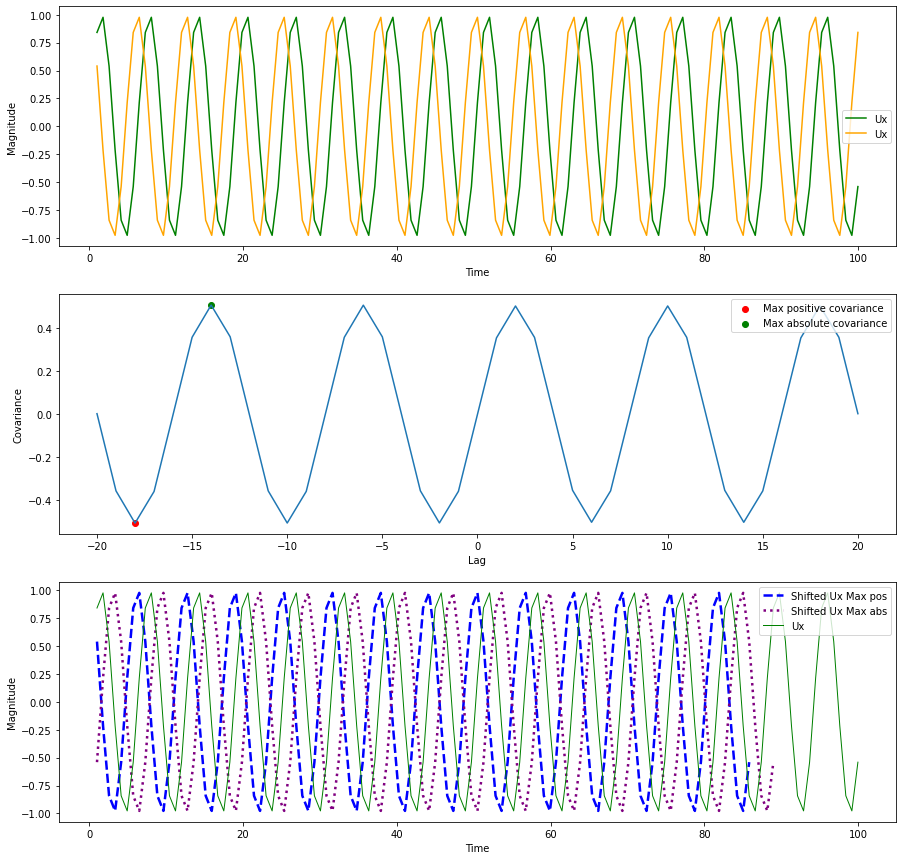

In [239]:
#t = np.linspace(1,1000,100)
t = np.arange(1,100, np.pi/4)
Ux = np.sin(t)
Uy = np.cos(t)
Uz = np.sin(t+np.pi)
q = np.sin(t)

df = pd.DataFrame([t, Ux, Uy,Uz,q],['t','Ux','Uy','Uz','q']).T.set_index('t')

fig, ax = plt.subplots(3,1)

x = Ux
y = Uy

xname = "Ux"
yname = "Ux"

ax[0].plot(t,x,label=xname,color='green')
ax[0].plot(t,y,label=yname,color='orange')
ax[0].legend()
ax[0].set_ylabel('Magnitude')
ax[0].set_xlabel('Time')

maxcov = max_covariance_v4(x, y,lag=14)
print(maxcov[0])
print(maxcov[1])
print(maxcov[2])


cov_df = pd.DataFrame.from_dict(maxcov[3],orient='index').sort_index()
ax[1].plot(cov_df.index, cov_df[0])
ax[1].scatter(*maxcov[1],color='red',label='Max positive covariance')
ax[1].scatter(*maxcov[0],color='green',label='Max absolute covariance')
ax[1].set_ylabel('Covariance')
ax[1].set_xlabel('Lag')
ax[1].legend()

df[f'{yname}_shift_1'] = df[yname].shift(maxcov[1][0])
df[f'{yname}_shift_2'] = df[yname].shift(maxcov[0][0])

ax[2].plot(df.index, df[f'{yname}_shift_1'], linestyle="--", linewidth=2.5,label=f"Shifted {yname} Max pos",color='blue',zorder=0)
ax[2].plot(df.index, df[f'{yname}_shift_2'], linestyle=":", linewidth=2.5,label=f"Shifted {yname} Max abs",color='purple',zorder=0)
ax[2].plot(t, Ux, label=xname ,zorder=2,color='green', linewidth=1.0)
#ax[2].plot(t, Uy, label='Uy',zorder=1,color='orange', linewidth=1.0)
ax[2].legend()
ax[2].set_ylabel('Magnitude')
ax[2].set_xlabel('Time')


In [235]:
%timeit max_covariance_v3(Ux, Uy, lag=10)

13.6 µs ± 340 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [237]:
%timeit max_covariance_v4(Ux, Uy, lag=10)

96.2 µs ± 3.7 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [112]:
%timeit calc_max_covariance(df, 'Ux','Uy')

(-10, -0.505978714790056)

In [ ]:
for i in range(1,lag+1):
    uxTs[i] = covux_Tsn[i]
    uyTs[i] = covuy_Tsn[i]
    uzTs[i] = covuz_Tsn[i]

    uxrhov[i] = covux_rhovn[i]
    uyrhov[i] = covuy_rhovn[i]
    uzrhov[i] = covuz_rhovn[i]

    uxq[i] = covux_qn[i]
    uyq[i] = covuy_qn[i]
    uzq[i] = covuz_qn[i]
    qTs[i] = covq_Tsn[i]

    uxTs[-1*lag + i] = covux_Ts[i]
    uyTs[-1*lag + i] = covuy_Ts[i]
    uzTs[-1*lag + i] = covuz_Ts[i]
    uxrhov[-1*lag + i] = covux_rhov[i]
    uyrhov[-1*lag + i] = covuy_rhov[i]
    uzrhov[-1*lag + i] = covuz_rhov[i]
    uxq[-1*lag + i] = covux_q[i]
    uyq[-1*lag + i] = covuy_q[i]
    uzq[-1*lag + i] = covuz_q[i]
    qTs[-1*lag + i] = covq_Ts[i]


In [10]:
#  Find Average of Square of Deviations from the Mean for Velocity Components and Humidity
sumx2 = np.sum(np.square(Ux - np.mean(Ux)))
sumy2 = np.square(Uy) + np.square(Uy - np.mean(Uy))
sumz2 = np.square(Uz) + np.square(Uz - np.mean(Uz))
sumqd2 = np.square(q) + np.square(q - np.mean(q))

ux2bar = sumx2 / len(Ux)
uy2bar = sumy2 / len(sumy2)
uz2bar = sumz2 / len(sumz2)
q2bar = sumqd2 / len(sumqd2)

In [11]:
ux2bar

0.5018228170335179

In [12]:
np.var(Ux)

0.5018228170335179

In [14]:
def sonic_to_air(Ts, P, rhov, Rv: float=461.51):
    """Convert sonic temperature into air temperature

    :param Ts: Sonic Temperature (K)
    :param rhov: Density of water vapor in air (kg/m3)
    :param Rv: Gas Constant of Water Vapor (J/(kg K))
    :return: Ta (air temperature, K)
    """
    # Ideal Gas Law to calculate vapor pressure
    e = rhov * Ts * Rv
    # molar mass of water vapor/ molar mass of dry air
    gamma = 0.622
    # calculate Specific Humidity
    q = (gamma * e) / (P - 0.378 * e)
    # Calculate air temperature from sonic temperature
    Ta = Ts / (1 + 0.51 * q)
    return Ta

#@numba.njit#(forceobj=True)
def calc_Tsa(Ts, P, pV, Rv=461.51):
    """
    Calculate the average sonic temperature
    :param Ts:
    :param P:
    :param pV:
    :param Rv:
    :return:
    """
    E = pV * Rv * Ts
    return -0.01645278052 * (
                -500 * P - 189 * E + np.sqrt(250000 * P ** 2 + 128220 * E * P + 35721 * E ** 2)) / pV / Rv

Ts = 300
P = 75060.5
pV = 0.013

print(sonic_to_air(Ts, P, pV))
print(calc_Tsa(Ts, P, pV))

297.71466689218505
297.73196927300484


In [ ]:
#@numba.njit#(forceobj=True)
def tetens(t, a=0.611, b=17.502, c=240.97):
    """Tetens formula for computing the
    saturation vapor pressure of water from temperature; eq. 3.8

    :param t: temperature (C)
    :param a: constant (kPa)
    :param b: constant (dimensionless)
    :param c: constant (C)
    :return: saturation vapor pressure (kPa)
    """
    return a * np.exp((b * t) / (t + c))


def calc_Es(T: float) -> float:
    """
    Saturation Vapor Pressure Equation
    :param T: Water temperature in Kelvin
    :return: Saturation Vapor Pressure (Pa)
    """
    g0 = -2836.5744
    g1 = -6028.076559
    g2 = 19.54263612
    g3 = -0.02737830188
    g4 = 0.000016261698
    g5 = 0.00000000070229056
    g6 = -0.00000000000018680009
    g7 = 2.7150305

    return np.exp(
        g0 * T ** (-2) + g1 * T ** (-1) + g2 + g3 * T + g4 * T ** 2 + g5 * T ** 3 + g6 * T ** 4 + g7 * np.log(T))

def sat_vapor_press(Tavg, eavg, Pavg):
    """Determine Saturation Vapor Pressure of the Air; Uses Highly Accurate Wexler's Equations Modified by Hardy

    :param Tavg:
    :return:
    """

    #  Coefficients for Saturation Vapor Pressure Equation
    g0 = -2.8365744E03
    g1 = -6.028076559E03
    g2 = 1.954263612E01
    g3 = -2.737830188E-02
    g4 = 1.6261698E-05
    g5 = 7.0229056E-10
    g6 = -1.8680009E-13
    g7 = 2.7150305

    #  Coefficients for Dew Point Equation
    cc0 = 2.0798233E02
    cc1 = -2.0156028E01
    cc2 = 4.6778925E-01
    cc3 = -9.2288067E-06

    lnes = g0 * Tavg ** (-2) + g1 * Tavg ** 1.0 + g2 + g3 * Tavg + g4 * Tavg ** 2.0 + g5 * Tavg ** 3.0 + g6 * Tavg ** 4 + g7 * np.log(Tavg)
    es = np.exp(lnes)

    lne = np.log(eavg)
    Td = (cc0 + cc1 * lne + cc2 * lne ** 2.0 + cc3 * lne ** 3.0) / (d0 + d1 * lne + d2 * lne ** 2.0 + d3 * lne ** 3.0)
    D = es - eavg

    Tq1 = Ta - 1.0
    lnes = g0 * Tq1 ** (-2) + g1 * Tq1 ** (-1) + g2 + g3 * Tq1 + g4 * Tq1 ** 2.0 + g5 * Tq1 ** 3.0 + g6 * Tq1 ** 4 + g7 * np.log(Tq1)
    es = np.exp(lnes)

    qs1 = (0.622 * es) / (Pavg - 0.378 * es)
    Tq2 = Ta + 1.0

    lnes = g0 * Tq2 ** (-2) + g1 * Tq2 ** (-1) + g2 + g3 * Tq2 + g4 * Tq2 ** 2.0 + g5 * Tq2 ** 3.0 + g6 * Tq2 ** 4 + g7 * np.log(Tq2)
    es = np.exp(lnes)

    qs2 = (0.622 * es) / (Pavg - 0.378 * es)
    s = (qs2 - qs1) / 2.0
    return es, s

In [ ]:
e=rhov(i)*Rv*Ts(i)
q(i)=(0.622*e)/(P(i)-0.378*e)
Ta=Ts(i)/(1+0.51*q(i))
lnes=g0*Ta**(-2)+g1*Ta**(-1)+g2+g3*Ta+g4*Ta**2.0+g5*Ta**3.0+g6*Ta**4.0+g7*ALOG(Ta)
es=EXP(lnes)
qs=(0.622*es)/(P(i)-0.378*es)
sumTa=sumTa+Ta
sumTa2=sumTa2+(Ta**2.0)
sume=sume+e
sumqm=sumqm+q(i)
sumq2=sumq2+q(i)**2.0


In [ ]:
def sat_vapor_press(Tavg, eavg, Pavg):
    """Determine Saturation Vapor Pressure of the Air; Uses Highly Accurate Wexler's Equations Modified by Hardy

    :param Tavg:
    :return:
    """

    lnes = g0 * Tavg ** (-2) + g1 * Tavg ** (1) + g2 + g3 * Tavg + g4 * Tavg ** 2.0 + g5 * Tavg ** 3.0 + g6 * Tavg ** 4 + g7 * np.log(Tavg)
    es = np.exp(lnes)

    lne = np.log(eavg)
    Td = (cc0 + cc1 * lne + cc2 * lne ** 2.0 + cc3 * lne ** 3.0) / (d0 + d1 * lne + d2 * lne ** 2.0 + d3 * lne ** 3.0)
    D = es - eavg

    Tq1 = Ta - 1.0
    lnes = g0 * Tq1 ** (-2) + g1 * Tq1 ** (-1) + g2 + g3 * Tq1 + g4 * Tq1 ** 2.0 + g5 * Tq1 ** 3.0 + g6 * Tq1 ** 4 + g7 * np.log(Tq1)
    es = np.exp(lnes)

    qs1 = (0.622 * es) / (Pavg - 0.378 * es)
    Tq2 = Ta + 1.0

    lnes = g0 * Tq2 ** (-2) + g1 * Tq2 ** (-1) + g2 + g3 * Tq2 + g4 * Tq2 ** 2.0 + g5 * Tq2 ** 3.0 + g6 * Tq2 ** 4 + g7 * np.log(Tq2)
    es = np.exp(lnes)

    qs2 = (0.622 * es) / (Pavg - 0.378 * es)
    s = (qs2 - qs1) / 2.0
    return s

In [15]:
def calc_cov(p1, p2):
    """
    Calculate covariance between two variables
    :param p1:
    :param p2:
    :return:
    """
    # p1mean = np.mean(p1)
    # p2mean = np.mean(p2)
    sumproduct = 0
    for i in range(len(p1)):
        sumproduct += p1[i] * p2[i]

    return (sumproduct - (np.sum(p1) * np.sum(p2)) / len(p1)) / (len(p1) - 1)

calc_cov(Ux,Uy)

0.004441481127834533

In [16]:
ux_ux = np.cov(Ux,Ux)[0][1]
ux_uy = np.cov(Ux,Uy)[0][1]
ux_uz = np.cov(Ux,Uz)[0][1]
uy_uy = np.cov(Uy,Uy)[0][1]
uy_uz = np.cov(Uy,Uz)[0][1]
uz_uz = np.cov(Uz,Uz)[0][1]
print(ux_ux)
print(ux_uy)
print(ux_uz)
print(uy_uz)
print(uz_uz)

0.5068917343772912
0.00444148112783453
-0.5068917343772907
-0.00444148112782985
0.5068917343772906


array([[5.06891734e-01, 9.16800595e-02],
       [9.16800595e-02, 8.41666667e+02]])